# Network Analysis with NetworkX
# Analysis of letters between American Founders
# Dataset source: https://repository.upenn.edu/entities/dataset/fcb53cbb-8254-4297-a40f-54be78550a91

We want to investigate a subset of the letter network between American Founders in the 18th century. We aim to answer the following questions:

Who wrote letters to whom?
Who received letters from whom?
Can we identify communities within the network?


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import community
import seaborn as sns
%matplotlib inline

In [2]:
# Import dataset
data = pd.read_csv("founders_online_network.csv")

In [3]:
data.head(10)

,title,project,permalink,year,month,day,source,year source,source gender,target,year target,target gender
0,"From Benjamin Franklin to Sir Hans Sloane, 2 J...",Franklin Papers,http://founders.archives.gov/documents/Frankli...,1725.0,6.0,2.0,"Franklin, Benjamin",1725.0,M,"Sloane, Sir Hans",1725.0,M
1,"From Benjamin Franklin to Jane Franklin, 6 Jan...",Franklin Papers,http://founders.archives.gov/documents/Frankli...,1727.0,1.0,6.0,"Franklin, Benjamin",1727.0,M,"Franklin, Jane",1727.0,F
2,"From Benjamin Franklin to Sarah Davenport, [Ju...",Franklin Papers,http://founders.archives.gov/documents/Frankli...,1730.0,6.0,1.0,"Franklin, Benjamin",1730.0,M,"Davenport, Sarah",1730.0,F
3,To Benjamin Franklin from Hugh Meredith: Disso...,Franklin Papers,http://founders.archives.gov/documents/Frankli...,1730.0,7.0,14.0,"Meredith, Hugh",1730.0,M,"Franklin, Benjamin",1730.0,M
4,"To Benjamin Franklin from James Logan, 1 May 1731",Franklin Papers,http://founders.archives.gov/documents/Frankli...,1731.0,5.0,1.0,"Logan, James",1731.0,M,"Franklin, Benjamin",1731.0,M
5,"From Benjamin Franklin to Jane Mecom, 19 June ...",Franklin Papers,http://founders.archives.gov/documents/Frankli...,1731.0,6.0,19.0,"Franklin, Benjamin",1731.0,M,"Mecom, Jane",1731.0,F
6,Joseph Breintnall to Directors of Library Comp...,Franklin Papers,http://founders.archives.gov/documents/Frankli...,1731.0,11.0,8.0,"Breintnall, Joseph",1731.0,M,"Directors of Library Company,",1731.0,NaN
7,From Benjamin Franklin to Library Company Subs...,Franklin Papers,http://founders.archives.gov/documents/Frankli...,1732.0,3.0,25.0,"Franklin, Benjamin",1732.0,M,"Library Company of Philadelphia Subscribers,",1732.0,NaN
8,"Louis Timothée to the German Inhabitants, 6 Ma...",Franklin Papers,http://founders.archives.gov/documents/Frankli...,1732.0,5.0,6.0,"Timothée, Louis",1732.0,M,"German Inhabitants,",1732.0,M
9,"Joseph Breintnall to Peter Collinson, 7 Novemb...",Franklin Papers,http://founders.archives.gov/documents/Frankli...,1732.0,11.0,7.0,"Breintnall, Joseph",1732.0,M,"Collinson, Peter",1732.0,M


In [4]:
# Create subset with source and target only
data2 = data[["source", "target"]]

In [5]:
data2.head(10)

,source,target
0,"Franklin, Benjamin","Sloane, Sir Hans"
1,"Franklin, Benjamin","Franklin, Jane"
2,"Franklin, Benjamin","Davenport, Sarah"
3,"Meredith, Hugh","Franklin, Benjamin"
4,"Logan, James","Franklin, Benjamin"
5,"Franklin, Benjamin","Mecom, Jane"
6,"Breintnall, Joseph","Directors of Library Company,"
7,"Franklin, Benjamin","Library Company of Philadelphia Subscribers,"
8,"Timothée, Louis","German Inhabitants,"
9,"Breintnall, Joseph","Collinson, Peter"


In [6]:
data2.info()
# 163670 sources
# 163670 targets

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163670 entries, 0 to 163669
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   source  163670 non-null  object
 1   target  163670 non-null  object
dtypes: object(2)
memory usage: 2.5+ MB


In [7]:
# Check unique values and their counts for the column "source"
data2["source"].value_counts()

Jefferson, Thomas      18811
Washington, George     18360
Adams, John             7983
Madison, James          7394
Hamilton, Alexander     6532
                       ...  
De Viar, José              1
Owings, David              1
Woods, David               1
Gath, Samuel               1
Burchan, John              1
Name: source, Length: 15089, dtype: int64

In [8]:
# Get ratio instead of raw numbers using normalize=True
expected_ratio = data2["source"].value_counts(normalize=True)

# Round and then convert to percentage
expected_ratio = expected_ratio.round(10)*100

# convert to a DataFrame and store in variable "source_ratios"
# We'll use this variable to compare ratios for samples 
# selected using SRS and Stratified Sampling 
source_ratios = pd.DataFrame({"Expected":expected_ratio})
source_ratios

,Expected
"Jefferson, Thomas",11.493249
"Washington, George",11.217694
"Adams, John",4.877497
"Madison, James",4.517627
"Hamilton, Alexander",3.990957
...,...
"De Viar, José",0.000611
"Owings, David",0.000611
"Woods, David",0.000611
"Gath, Samuel",0.000611


In [9]:
# Create stratified subset to reduce computational resources (0,05% of dataset)

# Use groupby and apply to select sample 
# which maintains the population group ratios
df = data2.groupby("source").apply(
    lambda x: x.sample(frac=0.0005, random_state=123)
)

In [12]:
# inspect df dataframe

df.head()
# weird index

,source,target
58700,"Adams, Abigail Smith","Jefferson, Thomas"
151971,"Adams, John","De Windt, Caroline Amelia Smith"
53041,"Adams, John","Adams, John Quincy"
99134,"Adams, John","Wolcott, Oliver Jr."
111183,"Adams, John","Shaw, William Smith"


In [11]:
# Remove the extra index added by groupby()
df = df.droplevel(0)

In [13]:
# compare ratio of sources from data2 with df

# Ratio of selected items by the source
stratified_ratio = df["source"].value_counts(normalize=True)
# Convert to percentage
stratified_ratio = stratified_ratio.round(4)*100
# We did stratified sampling. Rename
stratified_ratio.name = "Stratified"

In [14]:
# Add it to the variable source_ratios which already has 
# the expected proportion
source_ratios = pd.concat([source_ratios, stratified_ratio], axis=1)
source_ratios

,Expected,Stratified
"Jefferson, Thomas",11.493249,27.27
"Washington, George",11.217694,27.27
"Adams, John",4.877497,12.12
"Madison, James",4.517627,12.12
"Hamilton, Alexander",3.990957,9.09
...,...,...
"De Viar, José",0.000611,NaN
"Owings, David",0.000611,NaN
"Woods, David",0.000611,NaN
"Gath, Samuel",0.000611,NaN


In [15]:
df.info()
# 33 sources
# 33 targets

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33 entries, 58700 to 11384
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   source  33 non-null     object
 1   target  33 non-null     object
dtypes: object(2)
memory usage: 792.0+ bytes


## Exploratory Data Analysis

In [16]:
df.isnull().sum()
# no missing values

source    0
target    0
dtype: int64

In [17]:
df.sort_values(by=["source", "target"])

,source,target
58700,"Adams, Abigail Smith","Jefferson, Thomas"
53041,"Adams, John","Adams, John Quincy"
151971,"Adams, John","De Windt, Caroline Amelia Smith"
111183,"Adams, John","Shaw, William Smith"
99134,"Adams, John","Wolcott, Oliver Jr."
149123,"Adams, John Quincy","Adams, Abigail Smith"
5410,"Franklin, Benjamin","Franklin, Deborah"
5491,"Franklin, Benjamin","LeRoy, Jean Baptiste"
69052,"Hamilton, Alexander","Davidson, John"
100255,"Hamilton, Alexander","Jackson, Daniel"


In [18]:
df["source"].unique()

array(['Adams, Abigail Smith', 'Adams, John', 'Adams, John Quincy',
       'Franklin, Benjamin', 'Hamilton, Alexander', 'Jefferson, Thomas',
       'Madison, James', 'Washington, George'], dtype=object)

In [19]:
df["source"].nunique()
# 8 founders wrote letters

8

In [20]:
top_8_sources = df["source"].value_counts().head(8)
top_8_sources

Jefferson, Thomas       9
Washington, George      9
Adams, John             4
Madison, James          4
Hamilton, Alexander     3
Franklin, Benjamin      2
Adams, Abigail Smith    1
Adams, John Quincy      1
Name: source, dtype: int64

Thomas Jefferson and George Washington wrote the most letters, followed by John Adams and James Madison.

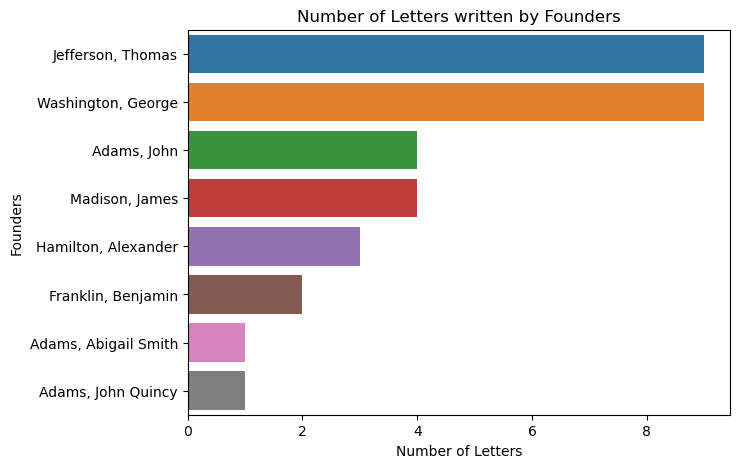

In [21]:
plt.figure(figsize=(7,5))
sns.barplot(y = df.source.value_counts().head(8).index,
            x = df.source.value_counts().head(8).values)
plt.xlabel("Number of Letters")
plt.ylabel("Founders")
plt.title("Number of Letters written by Founders");

In [22]:
df["target"].unique()

array(['Jefferson, Thomas', 'De Windt, Caroline Amelia Smith',
       'Adams, John Quincy', 'Wolcott, Oliver Jr.', 'Shaw, William Smith',
       'Adams, Abigail Smith', 'LeRoy, Jean Baptiste',
       'Franklin, Deborah', 'Lincoln, Benjamin', 'Davidson, John',
       'Jackson, Daniel', 'Gray, William F.', 'Ramsay, David',
       'Warden, David Bailie', 'Washington, George',
       'Langeac, August Louis Joseph Fidèle Amand de Lepinasse Comte de',
       'Van Staphorst & Hubbard,', 'Meriwether, William D.', 'Jefferson,',
       'Short, William', 'Peyton, Bernard', 'Roane, Spencer',
       'Jones, William', 'Hamilton, Alexander', 'Dick, Charles',
       'Madison, James', 'Lawrence, Charles', 'Reed, Joseph',
       'Robert Cary & Company,', 'Phelps, Oliver', 'Hopkinson, Joseph',
       'Pennsylvania Council of Safety,'], dtype=object)

In [23]:
df["target"].nunique()
# 32 founders received letters

32

In [24]:
top_32_targets = df["target"].value_counts().head(32)
top_32_targets

Jefferson, Thomas                                                  2
De Windt, Caroline Amelia Smith                                    1
Hopkinson, Joseph                                                  1
Phelps, Oliver                                                     1
Robert Cary & Company,                                             1
Reed, Joseph                                                       1
Lawrence, Charles                                                  1
Madison, James                                                     1
Dick, Charles                                                      1
Hamilton, Alexander                                                1
Jones, William                                                     1
Roane, Spencer                                                     1
Peyton, Bernard                                                    1
Short, William                                                     1
Jefferson,                        

Thomas Jefferson received the most letters.

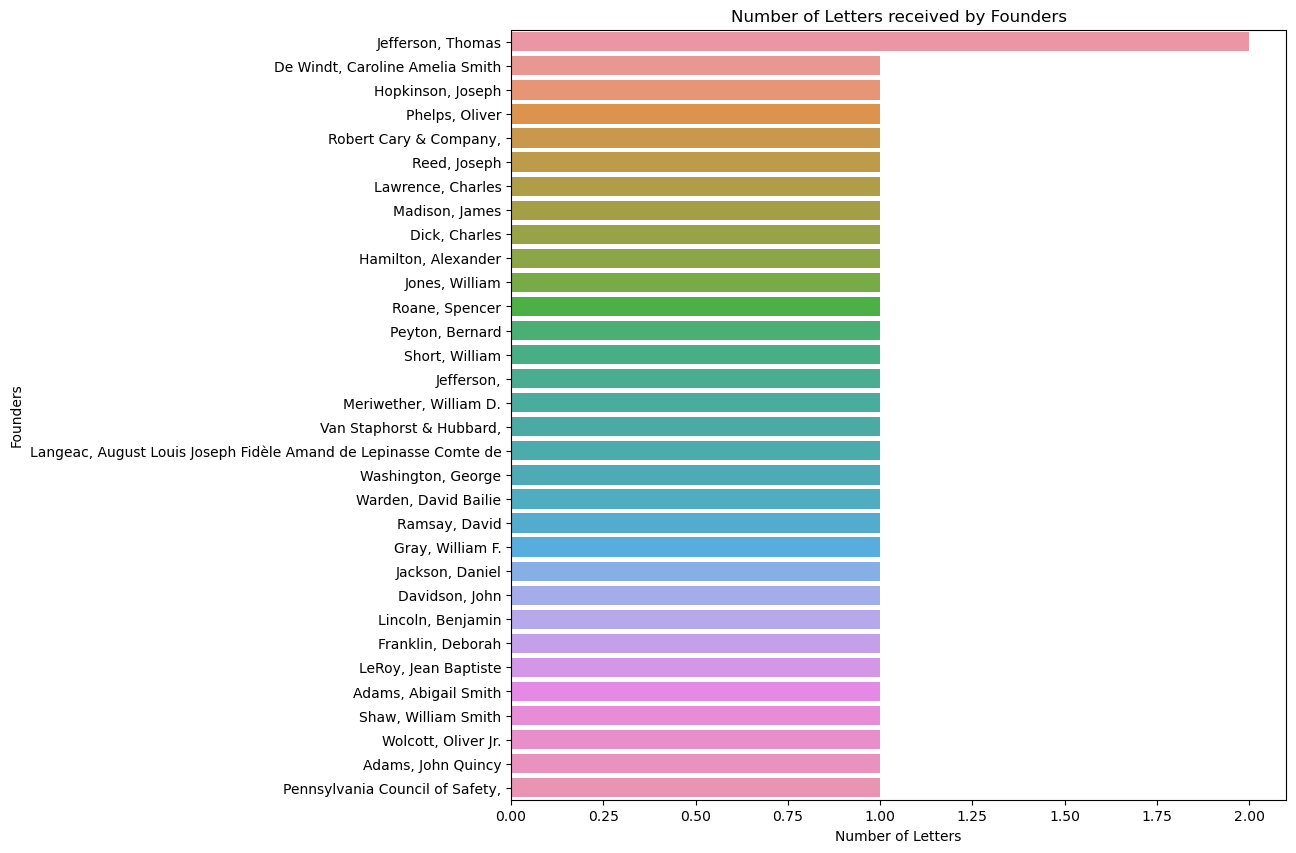

In [26]:
plt.figure(figsize=(10,10))
sns.barplot(y = df.target.value_counts().head(32).index,
            x = df.target.value_counts().head(32).values)
plt.xlabel("Number of Letters")
plt.ylabel("Founders")
plt.title("Number of Letters received by Founders");

In [27]:
df.value_counts()

source                target                                                         
Adams, Abigail Smith  Jefferson, Thomas                                                  1
Jefferson, Thomas     Van Staphorst & Hubbard,                                           1
Washington, George    Reed, Joseph                                                       1
                      Phelps, Oliver                                                     1
                      Pennsylvania Council of Safety,                                    1
                      Madison, James                                                     1
                      Lawrence, Charles                                                  1
                      Jefferson, Thomas                                                  1
                      Hopkinson, Joseph                                                  1
                      Dick, Charles                                                      1
Madi

# Data Pre-Processing

In [28]:
# Create pairs
df_pairs = pd.melt(df, id_vars=["source"], value_vars=["target"])
df_pairs = df_pairs.groupby(["source", "value"])["value"].count().reset_index(name="count")

In [29]:
founders = df["source"].unique().tolist() + df["target"].unique().tolist()
founders = list(set(founders))

In [30]:
# Create adjacency matrix
adj_matrix = pd.crosstab(df_pairs["source"], df_pairs["value"])

In [31]:
# Reindex the adjacency matrix to include all founders
adj_matrix = adj_matrix.reindex(index=founders, columns=founders, fill_value=0)

# Network Analysis

In [32]:
# Print the adjacency matrix
print(adj_matrix)     

value                                               Dick, Charles  \
source                                                              
Dick, Charles                                                   0   
Lawrence, Charles                                               0   
Meriwether, William D.                                          0   
Langeac, August Louis Joseph Fidèle Amand de Le...              0   
Pennsylvania Council of Safety,                                 0   
Roane, Spencer                                                  0   
Ramsay, David                                                   0   
Jackson, Daniel                                                 0   
Phelps, Oliver                                                  0   
Adams, Abigail Smith                                            0   
Franklin, Benjamin                                              0   
Madison, James                                                  0   
Adams, John                       

In [33]:
# Create a graph from the adjacency matrix
G = nx.from_pandas_adjacency(adj_matrix)

In [35]:
# List the names of the nodes
list(G.nodes)

['Dick, Charles',
 'Lawrence, Charles',
 'Meriwether, William D.',
 'Langeac, August Louis Joseph Fidèle Amand de Lepinasse Comte de',
 'Pennsylvania Council of Safety,',
 'Roane, Spencer',
 'Ramsay, David',
 'Jackson, Daniel',
 'Phelps, Oliver',
 'Adams, Abigail Smith',
 'Franklin, Benjamin',
 'Madison, James',
 'Adams, John',
 'Franklin, Deborah',
 'Gray, William F.',
 'Jefferson,',
 'LeRoy, Jean Baptiste',
 'Davidson, John',
 'Hamilton, Alexander',
 'Shaw, William Smith',
 'De Windt, Caroline Amelia Smith',
 'Warden, David Bailie',
 'Short, William',
 'Robert Cary & Company,',
 'Reed, Joseph',
 'Wolcott, Oliver Jr.',
 'Lincoln, Benjamin',
 'Washington, George',
 'Van Staphorst & Hubbard,',
 'Peyton, Bernard',
 'Adams, John Quincy',
 'Jefferson, Thomas',
 'Jones, William',
 'Hopkinson, Joseph']

In [36]:
nr_nodes = nx.number_of_nodes(G)
print("The network has: ",nr_nodes," nodes.")

# equivalent to: print("Number of nodes \t:", G.order())
# also possible to retrieve with:
# summary = nx.info(G)
# print(summary)

The network has:  34  nodes.


In [37]:
nr_edges = nx.number_of_edges(G)
print("The network has: ",nr_edges," edges.")

# equivalent to: print("Number of edges \t:", G.size())
# also possible to retrieve with:
# summary = nx.info(G)
# print(summary)

The network has:  32  edges.


In [38]:
# Calculate the average degree
average_degree = 2 * nr_edges / nr_nodes
print("That is, an average of ",average_degree," edges per node.")

That is, an average of  1.8823529411764706  edges per node.


In [39]:
# Check whether the network is connected
is_connected = nx.is_connected(G)
print("The founders letters network is", (1 - is_connected) * "not", "connected")

The founders letters network is not connected


In [40]:
print(nx.is_tree(G))
# we do not have a tree network

False


In [41]:
# List highest degree vertices
dict1 = dict(G.degree())
for founders in sorted(dict1, key=dict1.get)[-6:-1]:
    print(founders,  "is connected to", G.degree(founders), "other founders")

Adams, John Quincy is connected to 2 other founders
Adams, John is connected to 4 other founders
Hamilton, Alexander is connected to 4 other founders
Madison, James is connected to 5 other founders
Washington, George is connected to 9 other founders


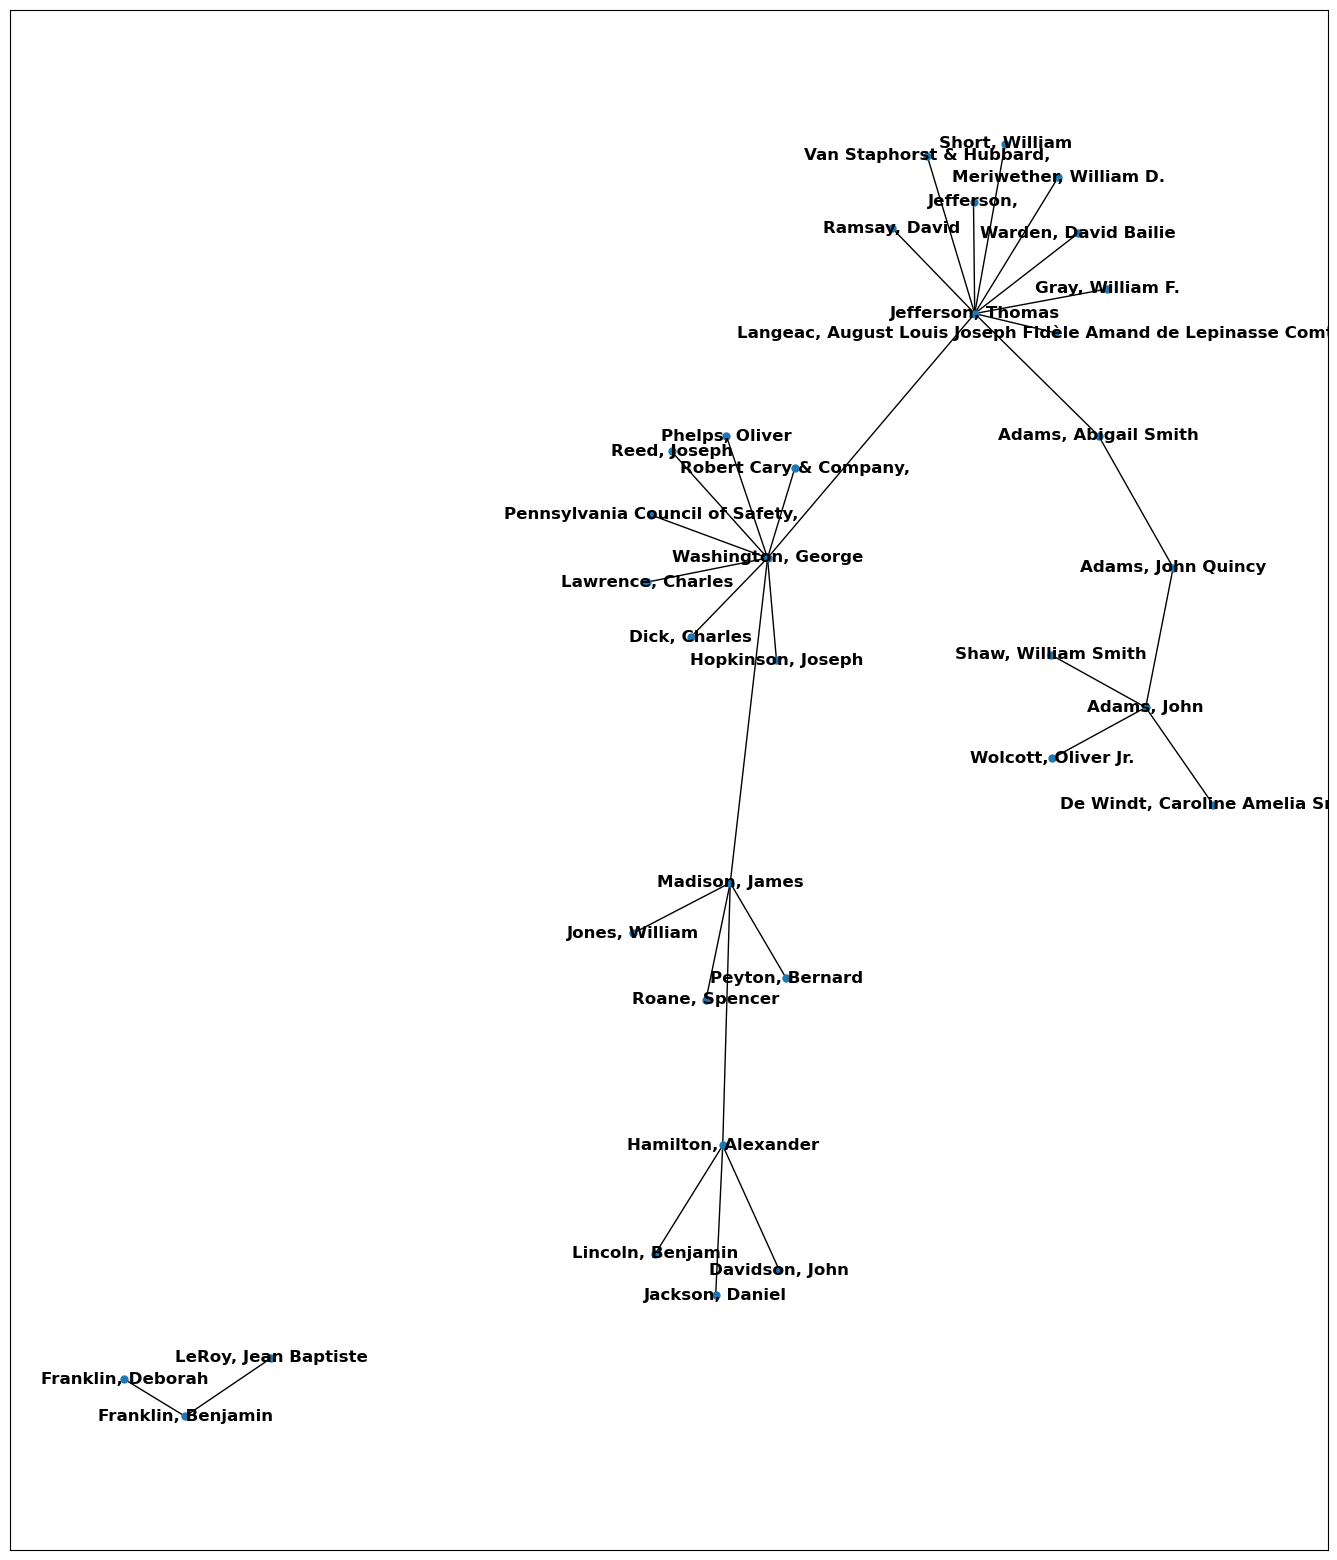

In [69]:
# Visualize the network
fig, ax = plt.subplots(figsize=(17, 20))
nx.draw_networkx(G, with_labels=True, node_size=25, font_weight="bold", ax=ax)
plt.show();

We have an unoriented graph.

## Identify communities within the network with Louvain method


In [70]:
# Perform community detection using the Louvain method
from community.community_louvain import best_partition
communities_Louvain = best_partition(G)

In [71]:
print("The best partition using the Louvain method is: \n", communities_Louvain)

The best partition using the Louvain method is: 
 {'Dick, Charles': 0, 'Lawrence, Charles': 0, 'Meriwether, William D.': 1, 'Langeac, August Louis Joseph Fidèle Amand de Lepinasse Comte de': 1, 'Pennsylvania Council of Safety,': 0, 'Roane, Spencer': 3, 'Ramsay, David': 1, 'Jackson, Daniel': 3, 'Phelps, Oliver': 0, 'Adams, Abigail Smith': 4, 'Franklin, Benjamin': 2, 'Madison, James': 3, 'Adams, John': 4, 'Franklin, Deborah': 2, 'Gray, William F.': 1, 'Jefferson,': 1, 'LeRoy, Jean Baptiste': 2, 'Davidson, John': 3, 'Hamilton, Alexander': 3, 'Shaw, William Smith': 4, 'De Windt, Caroline Amelia Smith': 4, 'Warden, David Bailie': 1, 'Short, William': 1, 'Robert Cary & Company,': 0, 'Reed, Joseph': 0, 'Wolcott, Oliver Jr.': 4, 'Lincoln, Benjamin': 3, 'Washington, George': 0, 'Van Staphorst & Hubbard,': 1, 'Peyton, Bernard': 3, 'Adams, John Quincy': 4, 'Jefferson, Thomas': 1, 'Jones, William': 3, 'Hopkinson, Joseph': 0}


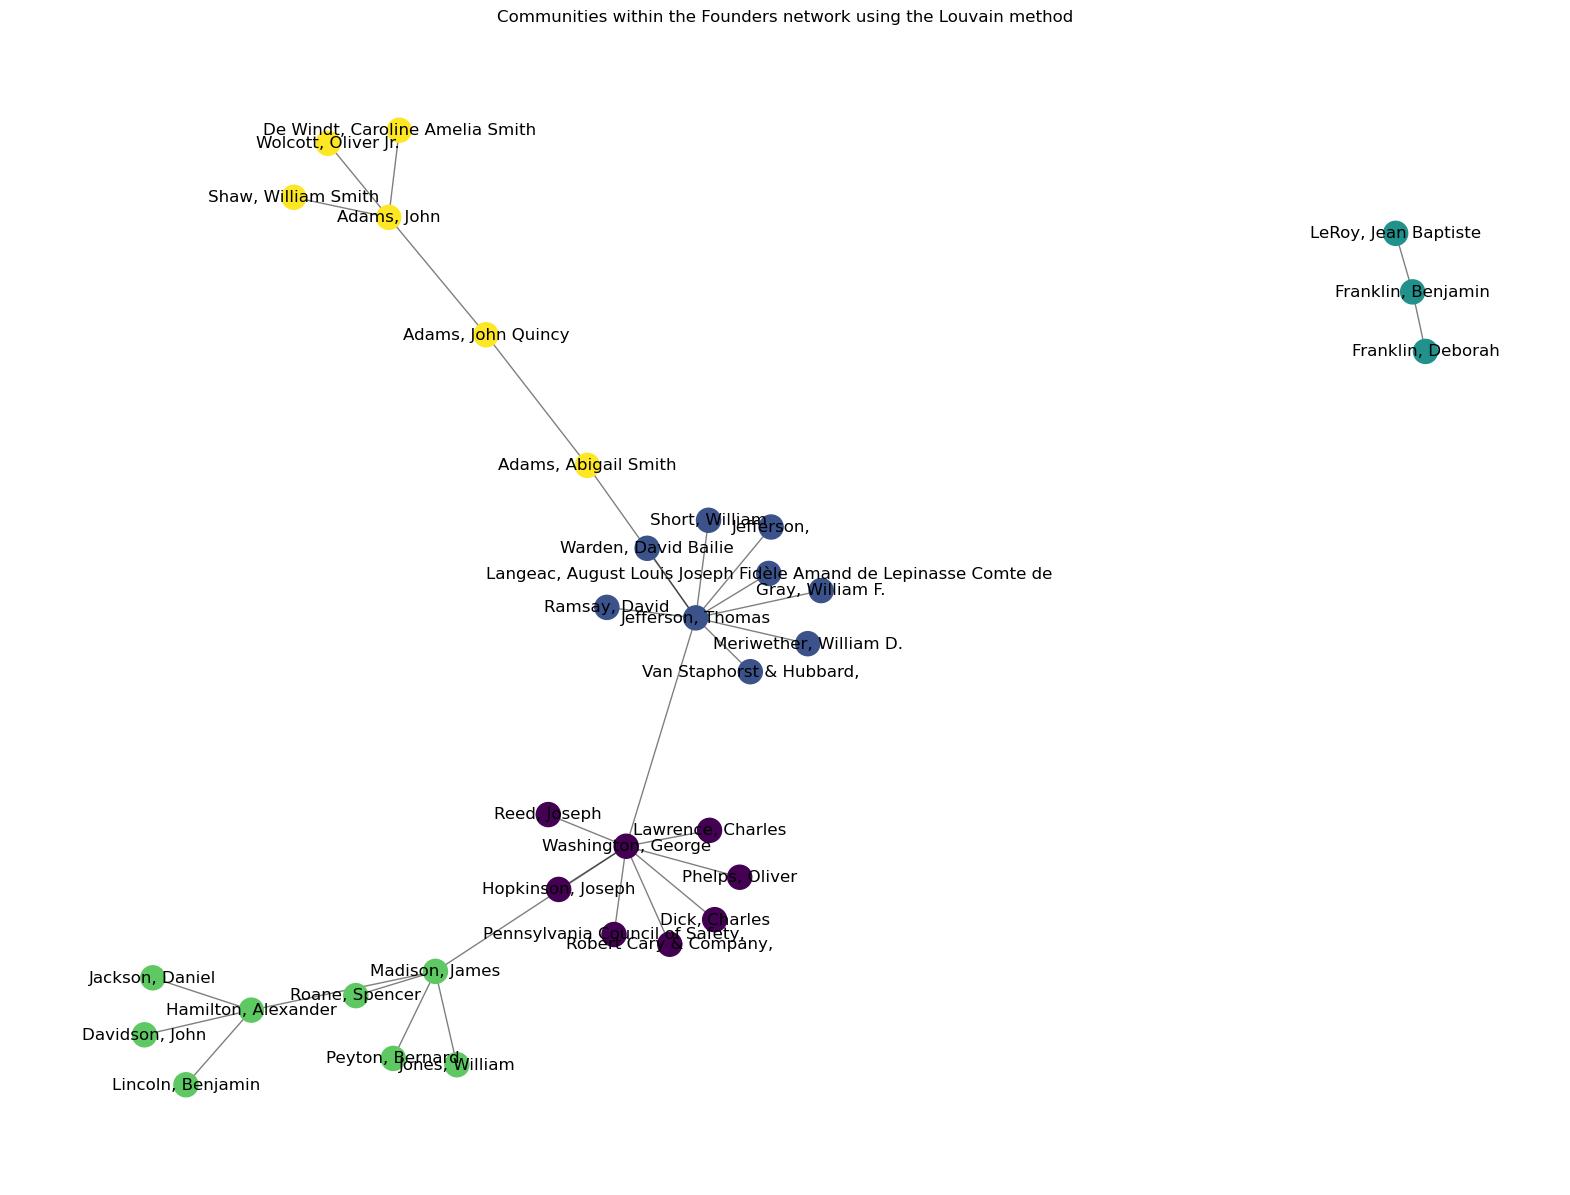

In [74]:
# Visualize the communities within the network
plt.figure(figsize=(20,15))
plt.axis("off")
plt.title("Communities within the Founders network using the Louvain method")
pos = nx.fruchterman_reingold_layout(G)
node_cluster = list(communities_Louvain.values())
nx.draw_networkx_nodes(G, pos, node_color = node_cluster)
nx.draw_networkx_edges(G, pos, alpha = 0.5)
nx.draw_networkx_labels(G, pos)
plt.show();

We identified 5 communities in the network:
1) Around John Adams (yellow)
2) Around George Washington (purple)
3) Around Benjamin Franklin (petrol)
4) Around Thomas Jefferson (blue)
5) Around James Madison and Alexander Hamilton (green)

In [75]:
# Evaluate quality of partitioning
from networkx.algorithms.community.quality import coverage

sequence = [list() for _ in range(len(communities_Louvain.items()))]
sorted_best_partition = sorted(communities_Louvain.items(), key=lambda t: t[1])
for e in sorted_best_partition:
    sequence[e[1]].append(e[0])

# Measure the quality of the Louvain method
print("This partitioning using the Louvain method obtains a coverage score of :", coverage(G, sequence))

This partitioning using the Louvain method obtains a coverage score of : 0.90625


## Identify communities within the network with Girvan Newman method


In [76]:
# Perform community detection using the Girvan Newman method
from networkx.algorithms.community import girvan_newman

communities_Girvan_Newman = nx.algorithms.community.girvan_newman(G)

In [77]:
community_Girvan_Newman = next(communities_Girvan_Newman)
community_Girvan_Newman

({'Davidson, John',
  'Dick, Charles',
  'Hamilton, Alexander',
  'Hopkinson, Joseph',
  'Jackson, Daniel',
  'Jones, William',
  'Lawrence, Charles',
  'Lincoln, Benjamin',
  'Madison, James',
  'Pennsylvania Council of Safety,',
  'Peyton, Bernard',
  'Phelps, Oliver',
  'Reed, Joseph',
  'Roane, Spencer',
  'Robert Cary & Company,',
  'Washington, George'},
 {'Adams, Abigail Smith',
  'Adams, John',
  'Adams, John Quincy',
  'De Windt, Caroline Amelia Smith',
  'Gray, William F.',
  'Jefferson,',
  'Jefferson, Thomas',
  'Langeac, August Louis Joseph Fidèle Amand de Lepinasse Comte de',
  'Meriwether, William D.',
  'Ramsay, David',
  'Shaw, William Smith',
  'Short, William',
  'Van Staphorst & Hubbard,',
  'Warden, David Bailie',
  'Wolcott, Oliver Jr.'},
 {'Franklin, Benjamin', 'Franklin, Deborah', 'LeRoy, Jean Baptiste'})

In [78]:
# Evaluate quality of partitioning
from networkx.algorithms.community.quality import performance
print("This partitioning using the Girvan Newman method obtains a performance score of :", performance(G, community_Girvan_Newman))

This partitioning using the Girvan Newman method obtains a performance score of : 0.6470588235294118


({'Dick, Charles'}, {'Lawrence, Charles'}, {'Meriwether, William D.'}, {'Langeac, August Louis Joseph Fidèle Amand de Lepinasse Comte de'}, {'Pennsylvania Council of Safety,'}, {'Roane, Spencer'}, {'Ramsay, David'}, {'Jackson, Daniel'}, {'Phelps, Oliver'}, {'Adams, Abigail Smith', 'Adams, John Quincy'}, {'Franklin, Benjamin', 'LeRoy, Jean Baptiste'}, {'Madison, James', 'Jones, William'}, {'Wolcott, Oliver Jr.', 'Adams, John'}, {'Franklin, Deborah'}, {'Gray, William F.'}, {'Jefferson,'}, {'Davidson, John'}, {'Lincoln, Benjamin', 'Hamilton, Alexander'}, {'Shaw, William Smith'}, {'De Windt, Caroline Amelia Smith'}, {'Warden, David Bailie'}, {'Short, William'}, {'Robert Cary & Company,'}, {'Reed, Joseph'}, {'Hopkinson, Joseph', 'Washington, George'}, {'Jefferson, Thomas', 'Van Staphorst & Hubbard,'}, {'Peyton, Bernard'})


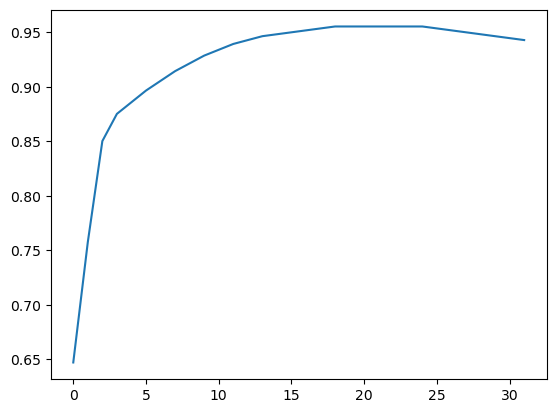

In [80]:
# Visualize optimal partitioning
communities_generator = nx.algorithms.community.girvan_newman(G)

# Initialize the variables necessary for the loop
best_score = 0
scores = []

# Performance measurement per partitioning
for partition in communities_generator :
    cur_score = performance(G, partition)
    
    if(cur_score >= best_score) :
        best_partition = partition
        best_score = cur_score
        
    scores.append(cur_score)

# Plot the performance per partitioning
plt.plot(range(len(scores)), scores);
print(best_partition);


Optimal number of communities seems to be from 5 upwards using the Girvan Newman method.